Imported Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/
%cp -av number-plate-detection/ ../../

/content/drive/MyDrive
'number-plate-detection/' -> '../../number-plate-detection'
'number-plate-detection/data.yaml' -> '../../number-plate-detection/data.yaml'
'number-plate-detection/TEST' -> '../../number-plate-detection/TEST'
'number-plate-detection/TEST/TEST.jpeg' -> '../../number-plate-detection/TEST/TEST.jpeg'
'number-plate-detection/TEST/TEST.mp4' -> '../../number-plate-detection/TEST/TEST.mp4'
'number-plate-detection/images' -> '../../number-plate-detection/images'
'number-plate-detection/images/N128.xml' -> '../../number-plate-detection/images/N128.xml'
'number-plate-detection/images/N121.xml' -> '../../number-plate-detection/images/N121.xml'
'number-plate-detection/images/N129.xml' -> '../../number-plate-detection/images/N129.xml'
'number-plate-detection/images/N124.xml' -> '../../number-plate-detection/images/N124.xml'
'number-plate-detection/images/N100.jpeg' -> '../../number-plate-detection/images/N100.jpeg'
'number-plate-detection/images/N118.xml' -> '../../number-plate

In [ ]:
%cd /content/drive/MyDrive/YoloModel
%cp best.onnx ../../../
%cp object_detection.h5 ../../../

/content/drive/MyDrive/YoloModel
cp: cannot stat 'best.onnx': No such file or directory


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import tf_keras as keras
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path = glob('/content/number-plate-detection/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [ ]:
df = pd.DataFrame(labels_dict)
df.to_csv('/content/labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0   /content/number-plate-detection/images/N30.xml   928  1219   543   606
1    /content/number-plate-detection/images/N4.xml  1326  1830  1464  1607
2   /content/number-plate-detection/images/N53.xml   217   428   147   188
3  /content/number-plate-detection/images/N175.xml   183   250   205   229
4  /content/number-plate-detection/images/N104.xml    66   154   166   197

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/number-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/number-plate-detection/images/N30.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:5]#random check

['/content/number-plate-detection/images/N30.jpeg',
 '/content/number-plate-detection/images/N4.jpeg',
 '/content/number-plate-detection/images/N53.jpeg',
 '/content/number-plate-detection/images/N175.jpeg',
 '/content/number-plate-detection/images/N104.jpeg']

In [ ]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [ ]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
imggg=[]
print(len(image_path))
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    imggg.append(load_image)
    data.append(norm_load_image_arr)
    output.append(label_norm)

225


In [ ]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = keras.Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Complie model

model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
tfb = TensorBoard('object_detection')
#INGET DISABLE COMMENT UTK TRAINING, SKRG PAKE PRETRAINED DI DRIVE JUSUP
# history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
#                    validation_data=(x_test,y_test),callbacks=[tfb])

In [ ]:
# model.save('/content/drive/MyDrive/object_detection.h5')

In [ ]:
# # Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/YoloModel/object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [ ]:
results = model.evaluate(x_test, y_test, batch_size=10)[1]
print(results)

5/5 [==============================] - 18s 3s/step - loss: 1.1579e-04 - accuracy: 1.0000
1.0


In [ ]:
path = '/content/number-plate-detection/TEST/TEST.jpeg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 729
Width of the image = 901


In [ ]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [ ]:
image_arr_224.shape

(224, 224, 3)

In [ ]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 6s 6s/step


array([[0.34616435, 0.6489796 , 0.63835746, 0.73037773]], dtype=float32)

In [ ]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[311.89407551, 584.73062342, 465.3625887 , 532.44536787]])

In [ ]:
coords = coords.astype(np.int32)
coords

array([[311, 584, 465, 532]], dtype=int32)

In [ ]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(311, 465) (584, 532)


In [ ]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

In [ ]:
# Create pipeline
path = '/content/number-plate-detection/TEST/TEST.jpeg'
def object_detection(path):

    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))

    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    # Make predictions
    coords = model.predict(test_arr)

    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 0s 388ms/step
(311, 465) (584, 532)


OCR


In [ ]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]

fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [ ]:

!pip install easyocr
import easyocr
from matplotlib import pyplot as plt
import numpy as np
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 29.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [ ]:

reader = easyocr.Reader(['en'])
result = reader.readtext(roi)
result

top_left = tuple(result[0][0][0])
bottom_right = tuple(result[0][0][2])
text = result[0][1]
font = cv2.FONT_HERSHEY_SIMPLEX

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

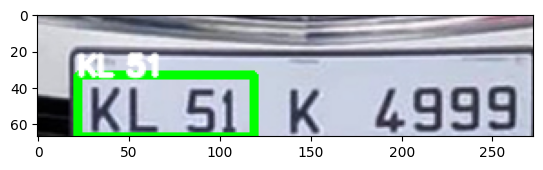

KL 51K49g9


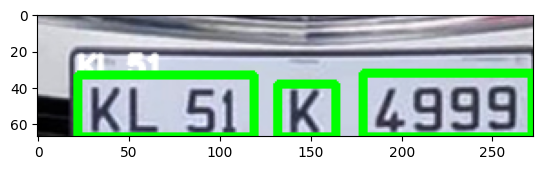

In [ ]:
img = roi
img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
img = cv2.putText(img,text,top_left, font, 0.5,(255,255,255),2,cv2.LINE_AA)
plt.imshow(img)
plt.show()
img = roi
spacer = 100
text = ""
for detection in result:
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text += detection[1]
    img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
    img = cv2.putText(img,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
    spacer+=15

print(text)
plt.imshow(img)
plt.show()

In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'/content/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)

    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0   /content/number-plate-detection/images/N30.xml   928  1219   543   606   
1    /content/number-plate-detection/images/N4.xml  1326  1830  1464  1607   
2   /content/number-plate-detection/images/N53.xml   217   428   147   188   
3  /content/number-plate-detection/images/N175.xml   183   250   205   229   
4  /content/number-plate-detection/images/N104.xml    66   154   166   197   

                                           filename  width  height  
0   /content/number-plate-detection/images/N30.jpeg   1600    1167  
1    /content/number-plate-detection/images/N4.jpeg   3644    2429  
2   /content/number-plate-detection/images/N53.jpeg    642     336  
3  /content/number-plate-detection/images/N175.jpeg    586     331  
4  /content/number-plate-detection/images/N104.jpeg    377     244

In [ ]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0   /content/number-plate-detection/images/N30.xml   928  1219   543   606   
1    /content/number-plate-detection/images/N4.xml  1326  1830  1464  1607   
2   /content/number-plate-detection/images/N53.xml   217   428   147   188   
3  /content/number-plate-detection/images/N175.xml   183   250   205   229   
4  /content/number-plate-detection/images/N104.xml    66   154   166   197   

                                           filename  width  height  center_x  \
0   /content/number-plate-detection/images/N30.jpeg   1600    1167  0.670937   
1    /content/number-plate-detection/images/N4.jpeg   3644    2429  0.433041   
2   /content/number-plate-detection/images/N53.jpeg    642     336  0.502336   
3  /content/number-plate-detection/images/N175.jpeg    586     331  0.369454   
4  /content/number-plate-detection/images/N104.jpeg    377     244  0.291777   

   center_y  bb_width  bb_height  
0  0.492288  0.181875   0.053985  
1  0.632153  0.138310   0.058872  
2  0.498512  0.328660   0.122024  
3  0.655589  0.114334   0.072508  
4  0.743852  0.233422   0.127049

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16793, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 16793 (delta 36), reused 91 (delta 19), pack-reused 16679
Receiving objects: 100% (16793/16793), 15.56 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (11515/11515), done.


In [ ]:
!pip install -r ./yolov5/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.4/799.4 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
imageio 

In [ ]:
!mkdir /content/yolov5/

mkdir: cannot create directory ‘/content/yolov5/’: File exists


In [ ]:
!mkdir /content/yolov5/data_images/

In [ ]:
!mkdir /content/yolov5/data_images/test/

In [ ]:
!mkdir /content/yolov5/data_images/train/

In [ ]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [ ]:
train_folder = '/content/yolov5/data_images/train'
values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

test_folder = '/content/yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]

    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')

    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)

        f.close()

Training Yolo


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch
torch.cuda.is_available()

import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=c5284ac65f665af9c0542eea7e1c7dad6657d8b1299882e9ddd3c37851c018d1
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [ ]:
# !python /content/yolov5/train.py --data /content/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

In [ ]:
# !python /content/yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

In [ ]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [ ]:
# LOAD THE IMAGE
img = io.imread('/content/number-plate-detection/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [ ]:
%cd /content/drive/MyDrive/YoloModel
%cp best\ \(2\).onnx ../../../

/content/drive/MyDrive/YoloModel


In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./best (2).onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]

    return input_image, detections

def non_maximum_supression(input_image,detections):

    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE

    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()

    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])
        # license_text = ''

        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

import pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:

import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [ ]:
# extrating text
def extract_text(image,bbox):

    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    if 0 in roi.shape:
        return 'no number'

    else:
        # img = roi
        # img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
        # img = cv2.putText(img,text,top_left, font, 0.5,(255,255,255),2,cv2.LINE_AA)
        # plt.imshow(img)
        # plt.show()

        global public_text_Easy
        global public_text_Pyte
        img = roi
        spacer = 100
        text = ""
        result = reader.readtext(roi)
        for detection in result:
            top_left = tuple(detection[0][0])
            bottom_right = tuple(detection[0][2])
            text += detection[1]
            img = cv2.rectangle(img,top_left,bottom_right,(0,255,0),3)
            img = cv2.putText(img,text,(20,spacer), font, 0.5,(0,255,0),2,cv2.LINE_AA)
            spacer+=15

        print('EasyOCR Prediction: ', text)
        public_text_Easy = text

        textByPT = pytesseract.image_to_string(roi, lang='eng') # Add language parameter
        # textByPT = textByPT.strip()
        print('Pytesseract Prediction: ', textByPT)
        public_text_Pyte = textByPT
        plt.imshow(img)
        plt.show()

        return text

In [ ]:
def get_iou_acc(bb1, bb2):
    # determine the coordinates of the intersection rectangle
    x_left = abs(bb1[0]-bb2[0])/max(0,bb2[0])
    y_top = abs(bb1[2]-bb2[2])/max(0,bb2[2])
    x_right = abs(bb1[1]-bb2[1])/max(0,bb2[1])
    y_bottom = abs(bb1[3]-bb2[3])/max(0,bb2[3])

    iou = x_left+y_top+x_right+y_bottom
    iou = iou/4

    return 100-(iou*100)

In [ ]:
def get_labels(pathh):
  print(pathh)
  path = glob.glob(str(pathh))
  labels = []
  for filename in path:
      info = xet.parse(filename)
      root = info.getroot()
      member_object = root.find('object')
      labels_info = member_object.find('bndbox')
      xmin = int(labels_info.find('xmin').text)
      xmax = int(labels_info.find('xmax').text)
      ymin = int(labels_info.find('ymin').text)
      ymax = int(labels_info.find('ymax').text)

      # labels_dict['filepath'].append(filename)
      labels.append(xmin)
      labels.append(ymin)
      labels.append(xmax-xmin)
      labels.append(ymax-ymin)
      print(labels)
  return labels

In [ ]:
# Model's Accuracy and Processing Time
import glob
import time
from skimage import io
test_images = glob.glob('/content/yolov5/data_images/test/*.jpeg')

accuracy = 0
cnt=0
cntTime=0
totalTime = 0
for image_path in test_images:
    xml_path = "/content/number-plate-detection/images/" + ((image_path.replace('.jpeg', '.xml')).split('/')[-1]) # Assume the XML files are named the same as the images
    labels = get_labels(xml_path)


    img = io.imread(image_path)
    start = time.time()
    input_image, detections = get_detections(img,net)
    end = time.time()
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)

    totalTime+=(end-start)
    cntTime+=1

    for x in boxes_np:
      accuracy+=get_iou_acc(x, labels)
      cnt+=1
      print(accuracy/cnt)

print(accuracy/cnt)
print(totalTime/cntTime)


/content/number-plate-detection/images/N200.xml
[196, 227, 246, 66]
95.84163722533076
96.01129182296008
95.98956555509994
96.04505226248268
96.2141492804473
96.0248585842417
/content/number-plate-detection/images/N207.xml
[213, 280, 126, 27]
96.34590441114024
96.76319341094377
97.05670102136801
97.2098272155275
97.2656720731909
97.38936994840422
97.5120944415876
97.65886237558492
/content/number-plate-detection/images/N20.xml
[498, 729, 298, 85]
97.2998848646792
97.03654963841659
96.84717687770595
96.75543161129355
96.62024364352894
96.60360755181811
/content/number-plate-detection/images/N164.xml
[248, 121, 173, 53]
96.48854655728958
96.38679266908026
96.31627254862293
96.2498303228425
96.18292312830368
96.08802718311935
96.05719136681226
96.03148219168975
95.98347430091079
95.98247653245075
96.02316755840518
96.03002352808471
96.0320849338285
96.03827533542619
/content/number-plate-detection/images/N101.xml
[31, 128, 108, 33]
96.02965179370865
96.02793737879435
96.00622589712482
95.9

In [ ]:
!pip install textdistance
import textdistance as td



------------------------------------------------------------------------------
image- 0
Actual Expected Text:  KL01KLKL01
EasyOCR Prediction:  KLO1KLKLo1
Pytesseract Prediction:  KLO1KLKLO1



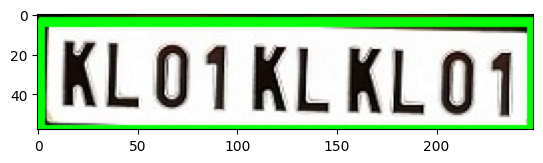

/content/yolov5/data_images/test/N200.jpeg
EasyOCR:  80.0 %
Pytesseract:  66.66666666666667 %


------------------------------------------------------------------------------
image- 1
Actual Expected Text:  MH 20 EE 0943
EasyOCR Prediction:  MH 20  EE0943
Pytesseract Prediction:  MH 20 EE! {0943



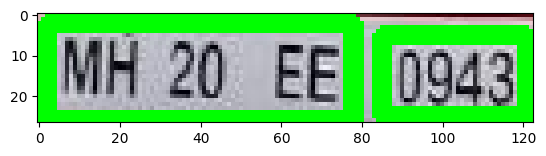

/content/yolov5/data_images/test/N207.jpeg
EasyOCR:  84.61538461538461 %
Pytesseract:  76.47058823529412 %


------------------------------------------------------------------------------
image- 2
Actual Expected Text:  JP 548 J
EasyOCR Prediction:  JP.548 ]
Pytesseract Prediction:  


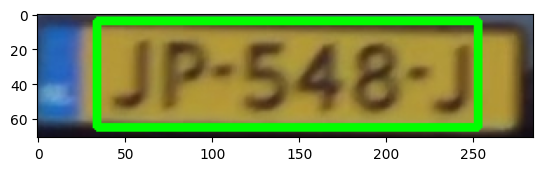

/content/yolov5/data_images/test/N20.jpeg
EasyOCR:  75.0 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 3
Actual Expected Text:  KL01CA2555
EasyOCR Prediction:  KLG1CA2555
Pytesseract Prediction:  KEG10A2555



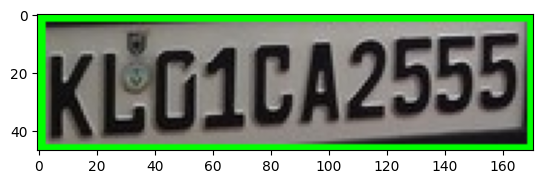

/content/yolov5/data_images/test/N164.jpeg
EasyOCR:  90.0 %
Pytesseract:  58.33333333333333 %


------------------------------------------------------------------------------
image- 4
Actual Expected Text:  WOB NP 300
EasyOCR Prediction:  VOBeNP 3go
Pytesseract Prediction:  WOBeNP 300)



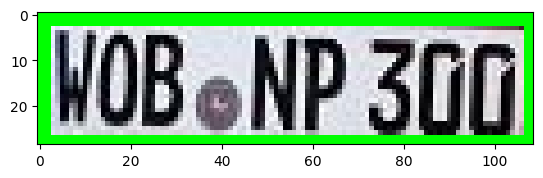

/content/yolov5/data_images/test/N101.jpeg
EasyOCR:  60.0 %
Pytesseract:  69.23076923076923 %


------------------------------------------------------------------------------
image- 5
Actual Expected Text:  KL 09 AL 9405
EasyOCR Prediction:  KL 09 Al %u05
Pytesseract Prediction:  DDT ee
Ke 09 ac guos

 

 



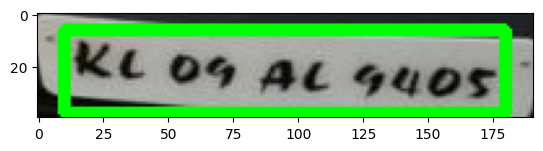

/content/yolov5/data_images/test/N162.jpeg
EasyOCR:  76.92307692307692 %
Pytesseract:  21.42857142857143 %


------------------------------------------------------------------------------
image- 6
Actual Expected Text:  KA 01 MA 6989
EasyOCR Prediction:  C NA6989
Pytesseract Prediction:   



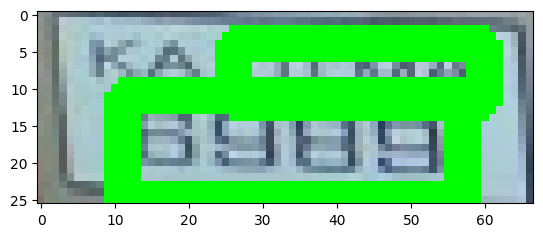

/content/yolov5/data_images/test/N113.jpeg
EasyOCR:  46.15384615384615 %
Pytesseract:  7.692307692307687 %


------------------------------------------------------------------------------
image- 7
Actual Expected Text:  MH 20 DV 2362
EasyOCR Prediction:  MH 20 DV 2362
Pytesseract Prediction:  MH 20 DV 2362),



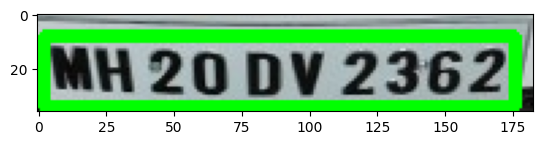

/content/yolov5/data_images/test/N242.jpeg
EasyOCR:  100.0 %
Pytesseract:  76.47058823529412 %


------------------------------------------------------------------------------
image- 8
Actual Expected Text:  MH 20 EE 7598


------------------------------------------------------------------------------
image- 8
Actual Expected Text:  MH 20 EE 7598
EasyOCR Prediction:  MH 20 EE 7598
Pytesseract Prediction:  MH 20 EE 7598



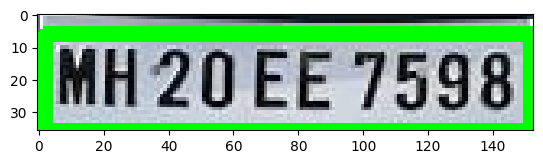

/content/yolov5/data_images/test/N239.jpeg
EasyOCR:  100.0 %
Pytesseract:  86.66666666666667 %


------------------------------------------------------------------------------
image- 9
Actual Expected Text:  TN59AQ1515
EasyOCR Prediction:  IN59A015157
Pytesseract Prediction:  


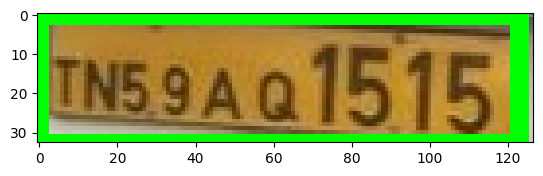

/content/yolov5/data_images/test/N237.jpeg
EasyOCR:  72.72727272727273 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 10
Actual Expected Text:  GJ07BR1336
EasyOCR Prediction:  INDJO7BRIDD
Pytesseract Prediction:  oR ( NE



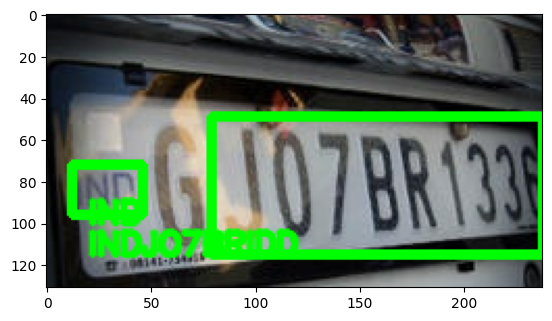

/content/yolov5/data_images/test/N123.jpeg
EasyOCR:  27.27272727272727 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 11
Actual Expected Text:  MH 20 BN 3525
EasyOCR Prediction:  MMHLQOBN 3525
Pytesseract Prediction:  


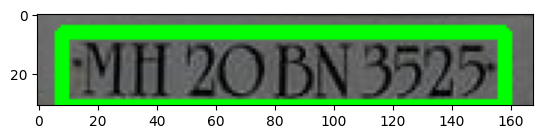

/content/yolov5/data_images/test/N220.jpeg
EasyOCR:  61.53846153846154 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 12
Actual Expected Text:  KA 05 HS 4495
EasyOCR Prediction:  KA05HS 4495
Pytesseract Prediction:  —— @

*K A OD

WS 4495



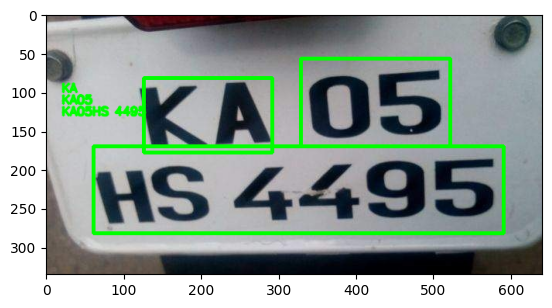

/content/yolov5/data_images/test/N235.jpeg
EasyOCR:  84.61538461538461 %
Pytesseract:  37.5 %


------------------------------------------------------------------------------
image- 13
Actual Expected Text:  MH03BS7778
EasyOCR Prediction:  MHD3BS 7778
Pytesseract Prediction:  IMHO3BS 7778



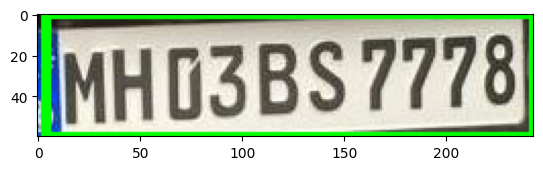

/content/yolov5/data_images/test/N99.jpeg
EasyOCR:  81.81818181818181 %
Pytesseract:  64.28571428571428 %


------------------------------------------------------------------------------
image- 14
Actual Expected Text:  PB08 CX 2959
EasyOCR Prediction:  PBO8 CX 2959]
Pytesseract Prediction:   

PBO8 CX 2959 |



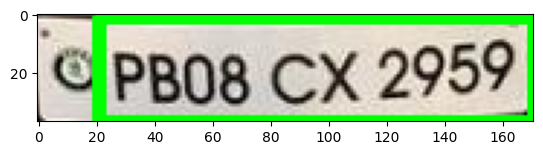

/content/yolov5/data_images/test/N153.jpeg
EasyOCR:  84.61538461538461 %
Pytesseract:  57.89473684210527 %


------------------------------------------------------------------------------
image- 15
Actual Expected Text:  KA 21 M 5519
EasyOCR Prediction:  "15319
Pytesseract Prediction:  


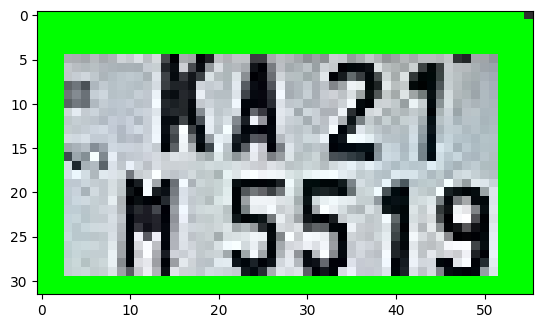

EasyOCR Prediction:  
Pytesseract Prediction:  


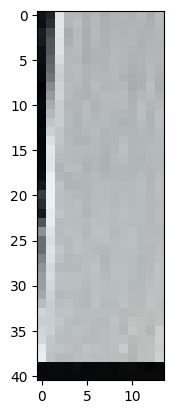

/content/yolov5/data_images/test/N222.jpeg
EasyOCR:  0.0 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 16
Actual Expected Text:  MH 14 EH 5819
EasyOCR Prediction:  MH 14EH5819
Pytesseract Prediction:  WH 14EH5819.



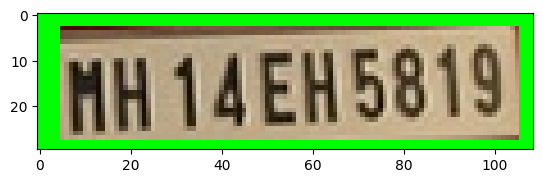

/content/yolov5/data_images/test/N98.jpeg
EasyOCR:  84.61538461538461 %
Pytesseract:  57.14285714285714 %


------------------------------------------------------------------------------
image- 17
Actual Expected Text:  KL 05 AK 3300


------------------------------------------------------------------------------
image- 17
Actual Expected Text:  KL 05 AK 3300
EasyOCR Prediction:  KLO5AK3300
Pytesseract Prediction:   

KOS AK 200)



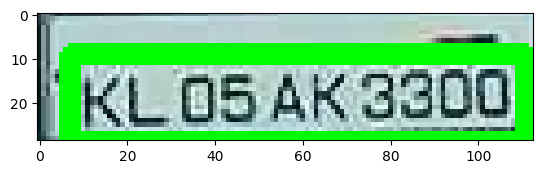

/content/yolov5/data_images/test/N244.jpeg
EasyOCR:  69.23076923076923 %
Pytesseract:  31.25 %


------------------------------------------------------------------------------
image- 18
Actual Expected Text:  KA 01 D 1330
EasyOCR Prediction:  Ka 011330
Pytesseract Prediction:  


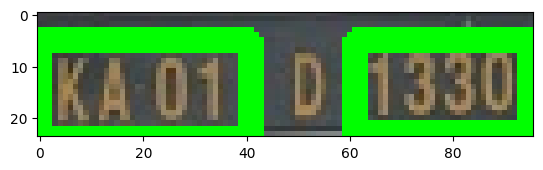

/content/yolov5/data_images/test/N160.jpeg
EasyOCR:  66.66666666666667 %
Pytesseract:  0.0 %


------------------------------------------------------------------------------
image- 19
Actual Expected Text:  TN 07 BU 5427
EasyOCR Prediction:  IH07 BU5L27
Pytesseract Prediction:  THO7BU5427



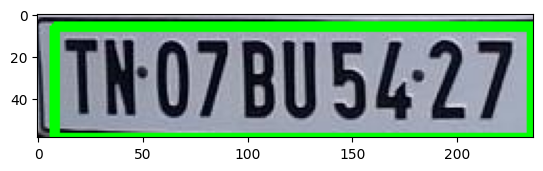

/content/yolov5/data_images/test/N247.jpeg
EasyOCR:  61.53846153846154 %
Pytesseract:  46.15384615384615 %


------------------------------------------------------------------------------
image- 20
Actual Expected Text:  KA51MJ8156


------------------------------------------------------------------------------
image- 20
Actual Expected Text:  KA51MJ8156
EasyOCR Prediction:  KA51MJ8156
Pytesseract Prediction:  iKAS 1MJ8 156)



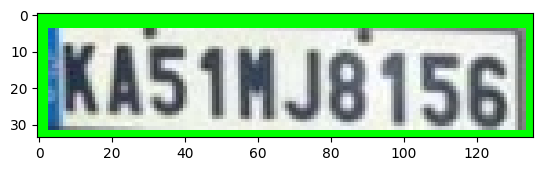

/content/yolov5/data_images/test/N44.jpeg
EasyOCR:  100.0 %
Pytesseract:  56.25 %


------------------------------------------------------------------------------
image- 21
Actual Expected Text:  KL07CB8599
EasyOCR Prediction:  FKL07cB8599
Pytesseract Prediction:   



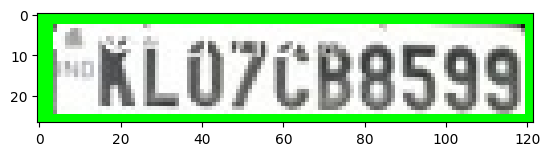

/content/yolov5/data_images/test/N198.jpeg
EasyOCR:  81.81818181818181 %
Pytesseract:  0.0 %
FINAL AVG EasyOCR 72.23405382496291 %
FINAL AVG Pytesseract 36.97439299606483 %


In [ ]:
# OCR Accuracy

cnt = 0
actualTexts = ['KL01KLKL01', 'MH 20 EE 0943', 'JP 548 J', 'KL01CA2555', 'WOB NP 300', 'KL 09 AL 9405', 'KA 01 MA 6989', 'MH 20 DV 2362', 'MH 20 EE 7598', 'TN59AQ1515', 'GJ07BR1336', 'MH 20 BN 3525', 'KA 05 HS 4495', 'MH03BS7778', 'PB08 CX 2959', 'KA 21 M 5519', 'MH 14 EH 5819', 'KL 05 AK 3300', 'KA 01 D 1330', 'TN 07 BU 5427', 'KA51MJ8156', 'KL07CB8599']
totalEasyOCR=0
totalPyte=0
for image_path in test_images:
  try:
    print('\n\n------------------------------------------------------------------------------\nimage-', cnt)
    print('Actual Expected Text: ',actualTexts[cnt])
    img = io.imread(image_path)
    results = yolo_predictions(img,net)
    print(image_path)

    EasyOCR = td.levenshtein.normalized_similarity(public_text_Easy, actualTexts[cnt])
    Pyte = td.levenshtein.normalized_similarity(public_text_Pyte, actualTexts[cnt])
    print('EasyOCR: ',EasyOCR*100,'%')
    print('Pytesseract: ',Pyte*100, '%')
    totalEasyOCR += EasyOCR
    totalPyte += Pyte
    cnt+=1
  except:
    continue

print('FINAL AVG EasyOCR', totalEasyOCR/cnt * 100, '%')
print('FINAL AVG Pytesseract', totalPyte/cnt * 100, '%')


In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()
